In [2]:
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import cdd
from modulus_tools import demo_graphs
from modulus_tools import algorithms as alg
from itertools import product

In [3]:
'slit trees with weights in edges'
def split_ew(G,w,ep):
    for i, (u,v) in enumerate(G.edges()):
        G[u][v]['enum'] = i
    for (a,b) in G.edges():
        H = G.copy()
        H.remove_edge(a,b)
        C =nx.connected_components(H)
        c= list(C)
        K = nx.Graph()
        c0= 0
        c1=0
        for u,v,d in H.edges(data=True):
            if u in c[0]:
                if v in c[0]:
                    c0= c0 + w[G[u][v]['enum']]
        for u,v,d in H.edges(data=True):
            if u in c[1]:
                if v in c[1]:
                    c1= c1 + w[G[u][v]['enum']]
        if abs(c0-c1)< ep :
            print('Splittable')
            print((a,b))
'split trees with weights in nodes'
def split_dw(G,w,ep):
    unsplittable = True
    for (a,b) in G.edges():
        H = G.copy()
        H.remove_edge(a,b)
        C =nx.connected_components(H)
        c= list(C)
        c0= sum(w[u] for u in c[0])
        c1=sum(w[u] for u in c[1])
        if abs(c0-c1)< ep+1 :
            unsplittable = False
            #print('Splittable')
            #print((a,b))
    if unsplittable is True:
        print('not - splittable')
    else:
        print('splittable')
'Minimum value of the optimal tree splitting'
def svalue(G,w):
    value = sum(w)
    cut = 0
    for (a,b) in G.edges():
        H = G.copy()
        H.remove_edge(a,b)
        C =nx.connected_components(H)
        c= list(C)
        c0= sum(w[u] for u in c[0])
        c1=sum(w[u] for u in c[1])
        if abs(c0-c1) < value :
            cut = (a,b)
            value = abs(c0-c1)
    return value, cut

In [4]:
'Computing modulus using fast algorithms'
def MOD(G):
    from modulus_tools.basic_algorithm import matrix_modulus, modulus
    from modulus_tools.families.networkx_families import MinimumSpanningTree
    from minimum_degree import VertexbasedMinimumSpanningTree
    m = len(G.nodes())
    pos = nx.spring_layout(G)
    mst = VertexbasedMinimumSpanningTree(G)
    mod, cons, rho, lam = modulus(m, matrix_modulus, mst, max_iter=400)
    print('modulus =', mod)
    print('rho =',rho)
    plt.figure(figsize=(6,6))
    nx.draw(G, pos, node_size=300, edge_color='black', width=2, node_color = np.around(rho,10), cmap=plt.cm.Set2)
    labels = {u:u for u in G.nodes}
    nx.draw_networkx_labels(G, pos,labels=labels, font_size=12)
    return mod, cons, rho, lam

In [5]:
'Compute modulus exactly'
def matrix_modulus(N, p=2, sigma=None):
    import cvxpy as cvx
    import numpy as np

    from warnings import warn
    
    # problem dimension
    m = N.shape[1]
    
    # set sigma to default if necessary
    if sigma is None:
        sigma = np.ones(m)
    
    # convert inputs to cvxpy constants
    N = cvx.Constant(N)
    sigma = cvx.Constant(sigma)
    
    # primal variables
    rho = cvx.Variable(m)
    
    # objective
    if p is not np.inf:
        obj = cvx.Minimize(sigma.T@rho**p)
    else:
        obj = cvx.Minimize(cvx.max(cvx.multiply(sigma, rho)))
        
    # constraints
    cons = [rho >= 0, N@rho >= 1]
    
    # set up the problem
    prob = cvx.Problem(obj, cons)
    
    # attempt to solve
    prob.solve()
    if prob.status != 'optimal':
        warn('cvxpy solve returned status {}'.format(prob.status))
        
    return prob.value, np.array(rho.value).flatten(), np.array(cons[1].dual_value).flatten()

In [6]:
'Matrix usage of vertex-based'
def matrixtree(G):
    for i, (u,v) in enumerate(G.edges()):
        G[u][v]['enum'] = i
    # get a list of spanning trees
    trees = list(alg.spanning_trees(G))
    # count the number of edges
    m = len(G.nodes)
    # initialize an empty list of rows for the augmented matrix
    rows = []
    for tree in trees:
        H = nx.Graph(tree)
        row = m*[0]
        for u in H.nodes:
            row[u] = H.degree[u]
        rows.append(row) 
    return np.array(rows)

In [7]:
''
def drawfair(G,ep):
    'Modulus'
    trees = list(alg.spanning_trees(G))
    N = matrixtree(G)
    mod,rho,lamb = matrix_modulus(N,p=2, sigma=None)
    'lambda'
    la = np.round(lamb/sum(lamb),8)
    'Draw G'
    n= len(G.nodes())
    pos = nx.spring_layout(G,seed= 123)
    nx.draw(G, pos, node_size=20, node_color =np.round(rho,5), edge_color='tab:blue', width=2)
    'weights in nodes to split'
    w = np.ones(n)
    ncol = 4
    nrow = int(np.ceil(400/ncol))
    plt.figure(figsize=(3*ncol,3*nrow))
    'draw fair trees'
    a=0
    b=0
    c=0
    for i,tree in enumerate(trees):
        if la[i]>0:
            a=a+1
            H= nx.Graph(tree)
            plt.subplot(nrow,ncol,a)
            value,cut = svalue(H,w)
            'draw splitable fair trees'
            if value < ep+1:
                c=c+1
                pos = nx.spring_layout(H)
                ax = plt.gca()
                ax.set_title(la[i])
                nx.draw(H, pos, node_size=20, edge_color='tab:blue', width=2, node_color = 'black')
                labels = {cut:value}
                nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=12)
            else:
                'draw unsplitable fair trees'
                b=b+1
                pos = nx.spring_layout(H)
                ax = plt.gca()
                ax.set_title(la[i])
                nx.draw(H, pos, node_size=20, edge_color='yellow', width=2, node_color = 'black',ax=ax)
                labels = {cut:value}
                nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=12)
    print('Number of trees = ',len(trees))
    print('Number of fair trees = ',a)
    print('Number of splittable fair trees =',c)
    print('Number of unsplittable fair trees =',b)
    expected = 0
    for i,tree in enumerate(trees):
        H= nx.Graph(tree)
        value,cut = svalue(H,w)
        expected = expected + la[i]*value
    print('Expected value of the best cut of a tree= ',expected)
    
    'Probability of being unsplittable for a tree'
    Probability = 0
    for i,tree in enumerate(trees):
        H= nx.Graph(tree)
        value,cut = svalue(H,w)
        if value > ep:
            Probability = Probability + la[i]
    print('Probability of being unsplittable for a tree',Probability )
    var = (1/mod)/n - ((2*n-2)**2)/(n**2)
    print('Variance of the node usage = ',round(var,5))
    la = np.round(lamb/sum(lamb),8)
    print('Maximum value of mu*=',max(la))        
        

In [8]:
def drawbadfair(G,ep):
    trees = list(alg.spanning_trees(G))
    N = matrixtree(G)
    mod,rho,lamb = matrix_modulus(N,p=2, sigma=None)
    la = np.round(lamb/sum(lamb),8)
    n= len(G.nodes())
    pos = nx.spring_layout(G, seed = 123)
    nx.draw(G, pos, node_size=20, node_color =np.round(rho,5), edge_color='tab:blue', width=2)
    #G = nx.random_geometric_graph(n, 0.3, seed=seed)
    w = np.ones(n)
    ncol = 4
    nrow = int(np.ceil(400/ncol))
    plt.figure(figsize=(3*ncol,3*nrow))
    a=0
    b=0
    
    for i,tree in enumerate(trees):
        if la[i]>0:
            a=a+1
            H= nx.Graph(tree)
            value,cut = svalue(H,w)
            if value > ep:
                b=b+1
                plt.subplot(nrow,ncol,b)    
                pos = nx.spring_layout(H)
                ax = plt.gca()
                ax.set_title(la[i])
                nx.draw(H, pos, node_size=20, edge_color='yellow', width=2, node_color = 'black', ax =ax)    
                labels = {cut:value}
                nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=12)
    print('Number of trees = ',len(trees))
    print('Number of fair trees = ',a)
    print('Number of unsplittable fair trees =',b)
    expected = 0
    for i,tree in enumerate(trees):
        H= nx.Graph(tree)
        value,cut = svalue(H,w)
        expected = expected + la[i]*value
    print('Expected value of the best cut of a tree = ',expected)
    
    'Probability of being unsplittable for a tree'
    Probability = 0
    for i,tree in enumerate(trees):
        H= nx.Graph(tree)
        value,cut = svalue(H,w)
        if value > ep:
            Probability = Probability + la[i]
    print('Probability of being unsplittable for a tree',Probability )
    var = (1/mod)/n - ((2*n-2)**2)/(n**2)
    print('Variance of the node usage = ',round(var,5))
    la = np.round(lamb/sum(lamb),8)
    print('Maximum value of mu*=',max(la)) 

## Splittability
Given a tree $\gamma$, the removal of an edge $e \in \gamma$ creates two components $\gamma_1$, $\gamma_2$, denote $ c(e) := \lvert n_1- n_2\rvert$ where $n_1$ and $n_2$ are the numbers of nodes of $\gamma_1$ and $\gamma_2$ respectively. Then,  denote the value of the best cut by $c(\gamma) := \min\limits_{e \in \gamma} c(e)$. A tree $\gamma$ is said to be splittable if $c(\gamma) \leq 1$ and unsplittable otherwise.

## Vertex-based spanning tree modulus

Let $G(V,E)$ be a connected graph, and let $\Gamma$ be the family of spanning trees. For each spanning tree $\gamma \in \Gamma$, we associate this spanning with a usage vector in $\mathbb{R}^V$ as follows: $ \mathcal{N}(\gamma, v) = \deg_{\gamma}(v) \text{ for all } \gamma \in \Gamma
 \text{ and } v \in V$.

A *density* on $G$ is a non-negative vector $\rho\in\mathbb{R}^V_{\ge 0}$. This induces on each $\gamma\in\Gamma$ a *total usage cost*, defined as

$$
\ell_\rho(\gamma) := \sum_{v\in V}\mathcal{N}(\gamma,v)\rho(v).
$$
 A density $\rho\in\mathbb{R}^V_{\ge 0}$ is said to be *admissible for $\Gamma$* if $\ell_{\rho}(\gamma)\ge 1$ for every $\gamma\in\Gamma$. In other words, $\rho$ is admissible if and only if $\mathcal{N}\rho\ge\mathbf{1}$ .
 
The *Vertex-based spanning tree modulus $\text{Mod}_2(\Gamma)$* is defined as follows

$$
\begin{split}
\text{minimize}\quad&\sum\limits_{v\in V}\rho(v)^2\\
\text{subject to}\quad&\rho\in\mathbb{R}^V_{\ge 0}\\
&\mathcal{N}\rho\ge\mathbf{1}.
\end{split}
$$

Let $\rho^*$ be the unique minimizer, then $\rho^*$ is called an *optimal density* or *extremal density*.

## Probabilistic interpretation

Let $\mathcal{P}(\Gamma)$ be the set of all *probability mass function (pmf)* of $\Gamma$, then $\text{Mod}_2(\Gamma)^{-1}$ is the value of the following optimization problem
$$
\begin{split}
\text{minimize}\quad&\sum\limits_{v\in V}\eta(v)^2\\
\text{subject to}\quad&\eta\in\mathbb{R}^V_{\ge 0}\\
&\eta = \mathbb{E}_{\mu} \left[ \mathcal{N}(\underline{\gamma},v) \right]\\
&\mu \in \mathcal{P}(\Gamma).
\end{split}
$$

The optimal pmf $\mu^*$ is not unique and the optimal density $\eta^*$ is unique. Notice that by the handshaking lemma, we have

$$ \sum\limits_{v\in V}\mathcal{N}(\gamma,v) = 2(|V|-1) \text{ for all } \gamma \in \Gamma .$$
 Given any pmf $\mu \in \mathcal{P}(\Gamma)$, let  $\eta(v)= \mathbb{E}_{\mu} \left[ \mathcal{N}(\underline{\gamma},v) \right]$, then we have $\sum\limits_{v\in V} \eta(v) = 2(|V|-1)$. 

Let $n = |V|$, we have $$ {\rm Var}(\eta) = \mathbb{E}[\eta^2] - (\mathbb{E}[\eta])^2 = \frac{1}{n}\sum\limits_{v\in V}\eta(v)^2 - \left( \frac{2n-2}{n} \right)^2 $$

Hence, minimizing $\sum\limits_{v\in V}\eta(v)^2$ is equivalent to minimizing ${\rm Var}(\eta)$. $G$ is said to be homogeneous if the the optimal density $\eta^*$ is constant, i.e, ${\rm Var}(\eta^*$) =0.

A spanning tree $\gamma \in \Gamma$ is called a  *fair tree* if there exists an optimal pmf $\mu^*$ such that $\mu^*(\gamma)>0.$ The set of all fair spanning trees for $G$ is denoted by $\Gamma^f$. A spanning tree which is  not a fair tree is called a *forbidden tree*.


## Fair trees and splittable trees.

We are interested in vertex-based spanning tree modulus and want to study the relation between fair trees and splittable trees. Let $\mu^*$ be a optimal pmf of the vertex-based spanning tree modulus problem. Based on $\mu^*$, we compute the followings:
 
1. We list all the fair trees that are unsplittable (yellow trees) and the fair trees that are splittable (blue trees) if they are not too many. The number above each tree is $\mu^*$ and the edge with a number on it is a best cut. 

2. Given a optimal pmf $\mu^*$, we compute the expected value of the $c(\gamma)$ and the probability of $\gamma$ being unsplittable.

3. We compute the variance of the node usage ${\rm Var}(\eta^*$).

4. We compute $|| \mu^*||_{\infty}$


Here are some example:

Example 1: The Square graph with a diagonal

Number of trees =  8
Number of fair trees =  4
Number of splittable fair trees = 4
Number of unsplittable fair trees = 0
Expected value of the best cut of a tree=  0.0
Probability of being unsplittable for a tree 0.0
Variance of the node usage =  0.0
Maximum value of mu*= 0.25


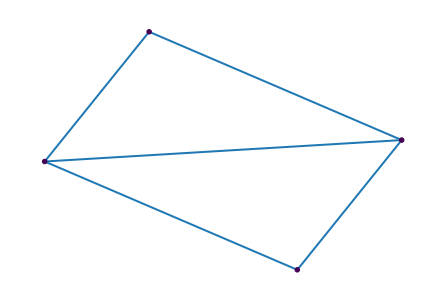

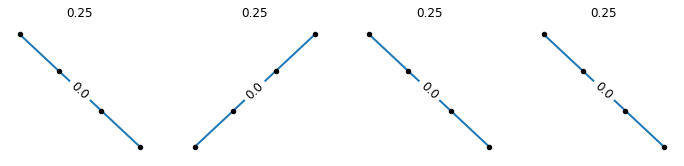

In [9]:
G = nx.Graph()
nx.add_path(G,(0,1,2,3,0))
nx.add_path(G,(1,3))
#N = matrixtree(G)
#n = len(G.nodes())
#mod,rho,lamb = matrix_modulus(N,p=2, sigma=None)
#print(rho)
#la = np.round(lamb/sum(lamb),8)
#print(la)
drawfair(G,1)

Example 2: Grid $3 \times 4$

Number of trees =  2415
Number of fair trees =  287
Number of unsplittable fair trees = 64
Expected value of the best cut of a tree =  0.4504861999999998
Probability of being unsplittable for a tree 0.19110097999999992
Variance of the node usage =  0.0
Maximum value of mu*= 0.01846307


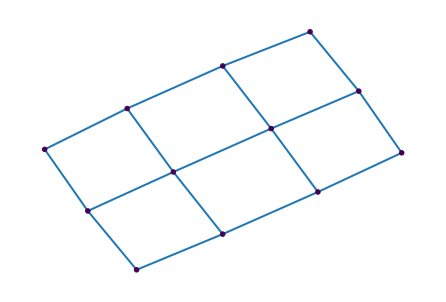

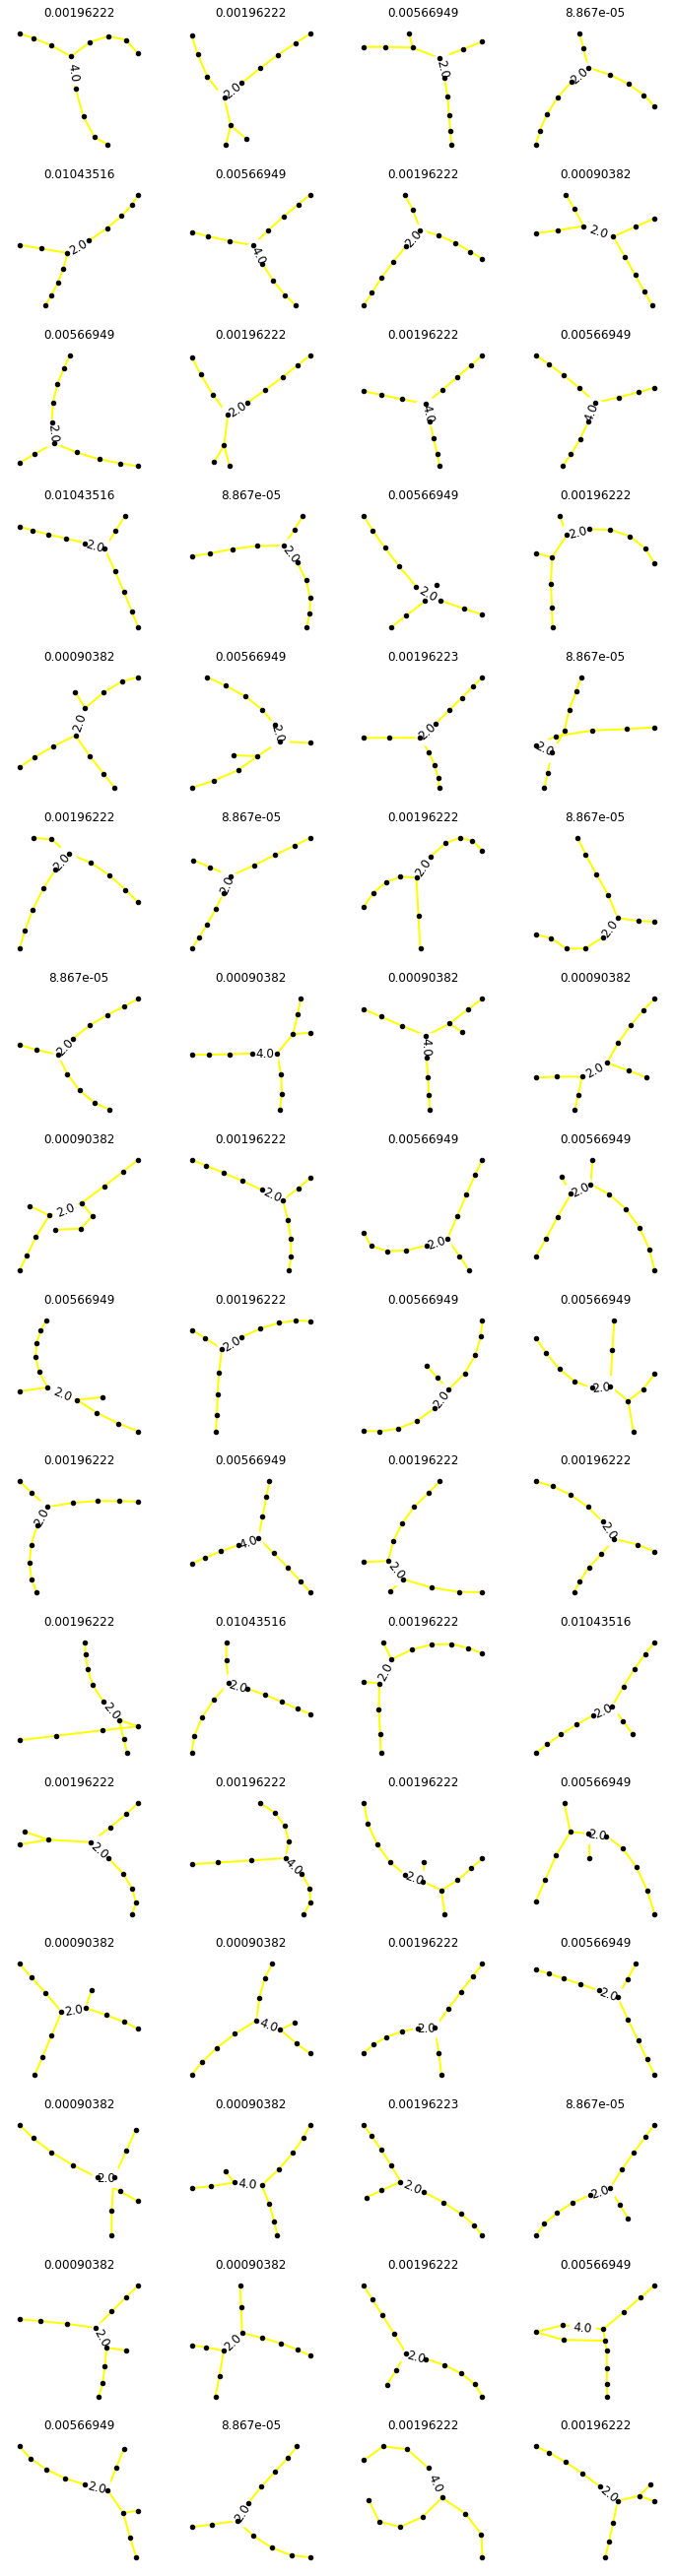

In [10]:
G = nx.Graph()
nx.add_path(G,(0,1,2,3,4,5,6,7,8,9,10,11,4))
nx.add_path(G,(2,5,10))
nx.add_path(G,(1,6,9))
nx.add_path(G,(0,7))
drawbadfair(G,1)


Example 3: Complete graph with $n =5$.

Number of trees =  125
Number of fair trees =  125
Number of unsplittable fair trees = 5
Expected value of the best cut of a tree =  1.0284672000000004
Probability of being unsplittable for a tree 0.0142336
Variance of the node usage =  0.0
Maximum value of mu*= 0.01137146


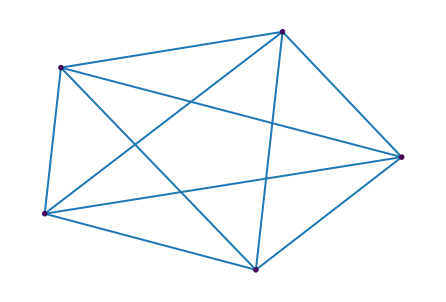

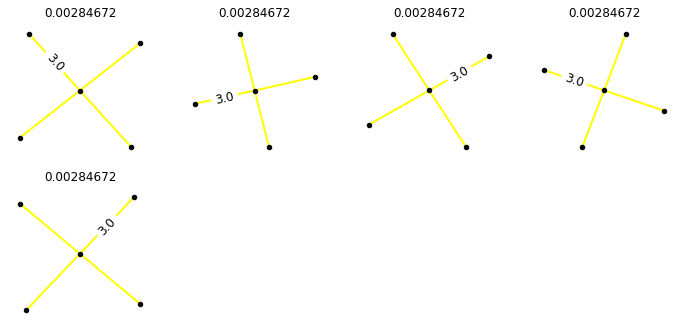

In [11]:
G = nx. complete_graph(5)
drawbadfair(G,1)
#N = matrixtree(G)
#mod,rho,lamb = matrix_modulus(N,p=2, sigma=None)
#la = np.round(lamb/sum(lamb),8)
#n = len(G.nodes())
#print(rho)
#print(la)

In [12]:
def drawfair(G,ep):
    trees = list(alg.spanning_trees(G))
    N = matrixtree(G)
    mod,rho,lamb = matrix_modulus(N,p=2, sigma=None)
    la = np.round(lamb/sum(lamb),8)
    n= len(G.nodes())
    pos = dict( zip( G.nodes(), G.nodes() ))
    nx.draw(G, pos, node_size=20, node_color =np.round(rho,5), edge_color='tab:blue', width=2)
    #G = nx.random_geometric_graph(n, 0.3, seed=seed)
    w = np.ones(n)
    ncol = 4
    nrow = int(np.ceil(400/ncol))
    plt.figure(figsize=(3*ncol,3*nrow))
    a=0
    b=0
    
    for i,tree in enumerate(trees):
        if la[i]>0:
            a=a+1
            H= nx.Graph(tree)
            value,cut = svalue(H,w)
            if value > ep:
                b=b+1
                plt.subplot(nrow,ncol,b)    
                pos = dict( zip( H.nodes(), H.nodes() ))
                ax = plt.gca()
                ax.set_title(la[i])
                nx.draw(H, pos, node_size=20, edge_color='yellow', width=2, node_color = 'black', ax =ax)    
                labels = {cut:value}
                nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=12)
    print('Number of trees = ',len(trees))
    print('Number of fair trees = ',a)
    print('Number of unsplittable fair trees =',b)
    expected = 0
    for i,tree in enumerate(trees):
        H= nx.Graph(tree)
        value,cut = svalue(H,w)
        expected = expected + la[i]*value
    print('Expected value of the best cut of a tree = ',expected)
    
    'Probability of being unsplittable for a tree'
    Probability = 0
    for i,tree in enumerate(trees):
        H= nx.Graph(tree)
        value,cut = svalue(H,w)
        if value > ep:
            Probability = Probability + la[i]
    print('Probability of being unsplittable for a tree',Probability )
    var = (1/mod)/n - ((2*n-2)**2)/(n**2)
    print('Variance of the node usage = ',round(var,5))
    la = np.round(lamb/sum(lamb),8)
    print('Maximum value of mu*=',max(la)) 

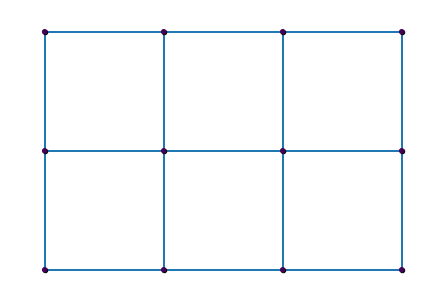

In [35]:
'Grid 3.4'
import math
n = 3
m =4
G = nx.grid_2d_graph(4,3)
'draw G'
pos = dict(zip(G.nodes(),G.nodes()))
nx.draw(G, pos, node_size=20, node_color ='black', edge_color='tab:blue', width=2)

Number of trees =  2415
Number of fair trees =  287
Number of unsplittable fair trees = 64
Expected value of the best cut of a tree =  0.45048619999999984
Probability of being unsplittable for a tree 0.19110096999999995
Variance of the node usage =  0.0
Maximum value of mu*= 0.01846307


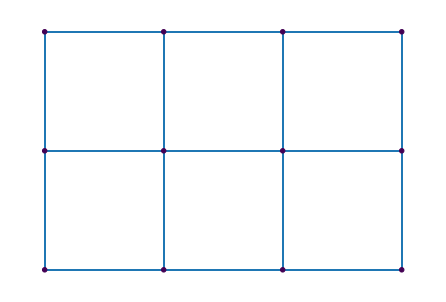

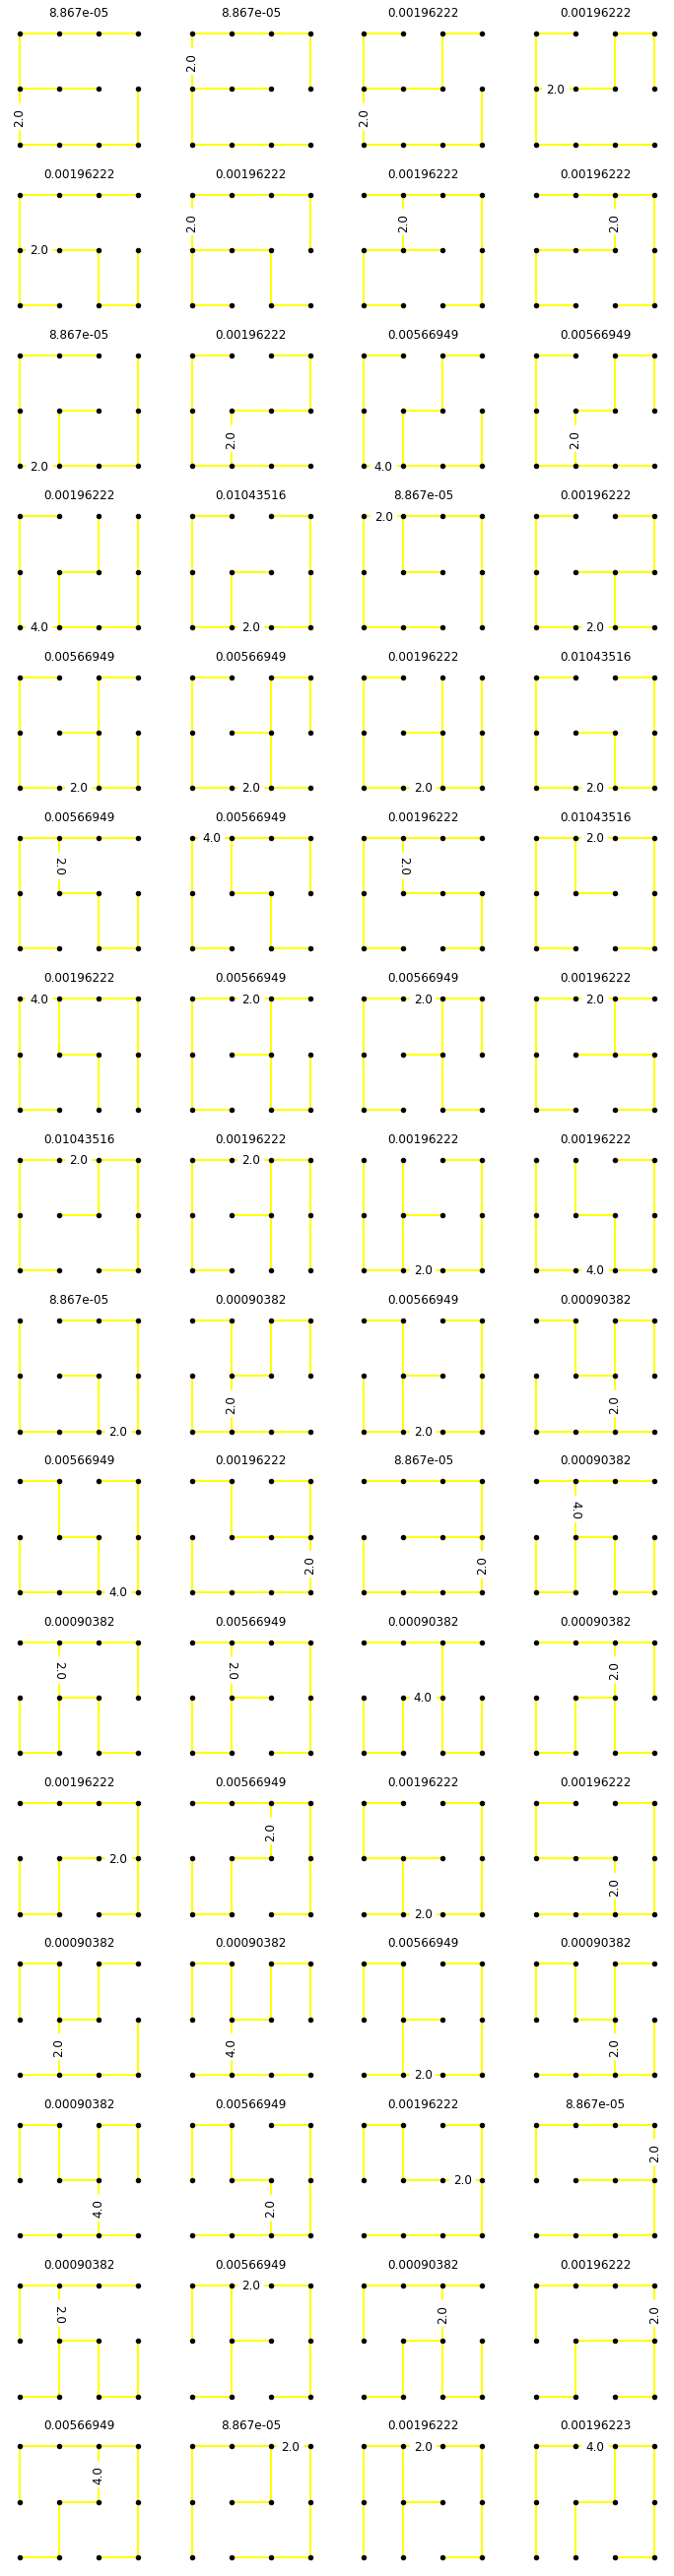

In [41]:
a1 = 4
a2 = 3
G = nx.grid_2d_graph(a1,a2)
'Relabel'
mapping = dict(zip(G, range(12)))
G = nx.relabel_nodes(G, mapping)
'modulus'
trees = list(alg.spanning_trees(G))
N = matrixtree(G)
mod,rho,lamb = matrix_modulus(N,p=2, sigma=None)
la = np.round(lamb/sum(lamb),8)

'draw G'
pos = {i:(math.floor((i)/a2),i-(math.floor((i)/a2))*a2) for i in G.nodes()}
nx.draw(G, pos, node_size=20, node_color =np.round(rho,5), edge_color='tab:blue', width=2)

'Draw fair trees'
ep = 1
n= len(G.nodes())
w = np.ones(n)
ncol = 4
nrow = int(np.ceil(400/ncol))
plt.figure(figsize=(3*ncol,3*nrow))
a=0
b=0
    
for i,tree in enumerate(trees):
    if la[i]>0:
        a=a+1
        H= nx.Graph(tree)
        value,cut = svalue(H,w)
        if value > ep:
            b=b+1
            plt.subplot(nrow,ncol,b)    
            pos = {i:(math.floor((i)/a2),i-(math.floor((i)/a2))*a2) for i in H.nodes()}
            ax = plt.gca()
            ax.set_title(la[i])
            nx.draw(H, pos, node_size=20, edge_color='yellow', width=2, node_color = 'black', ax =ax)    
            labels = {cut:value}
            nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=12)
print('Number of trees = ',len(trees))
print('Number of fair trees = ',a)
print('Number of unsplittable fair trees =',b)
expected = 0
for i,tree in enumerate(trees):
    H= nx.Graph(tree)
    value,cut = svalue(H,w)
    expected = expected + la[i]*value
print('Expected value of the best cut of a tree = ',expected)
    
'Probability of being unsplittable for a tree'
Probability = 0
for i,tree in enumerate(trees):
    H= nx.Graph(tree)
    value,cut = svalue(H,w)
    if value > ep:
        Probability = Probability + la[i]
print('Probability of being unsplittable for a tree',Probability )
var = (1/mod)/n - ((2*n-2)**2)/(n**2)
print('Variance of the node usage = ',round(var,5))
la = np.round(lamb/sum(lamb),8)
print('Maximum value of mu*=',max(la)) 